In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#to read the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 8 # this represents how many letters of context the model considers before choosing the next letter
def build_dataset(words):
    X, Y = [], []

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [7]:
# from the previous code
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layers

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g) #embeddings
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)# * 0.2 # best number to put this is divide by fanim (sqrt(n_embd * block_size))
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [8]:
# HAHAHAHAHA
# --------------------------------------------------------------------------------
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # Kaiming factor
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# --------------------------------------------------------------------------------
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers with momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
# --------------------------------------------------------------------------------

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# --------------------------------------------------------------------------------

class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# --------------------------------------------------------------------------------

class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
# --------------------------------------------------------------------------------

class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [15]:
n_embd = 24
n_hidden = 128
g = torch.Generator().manual_seed(2147483647)

#C = torch.randn((vocab_size, n_embd), generator=g)
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
])


with torch.no_grad():
    model.layers[-1].weight *= 0.1 #in order to make the last layer less confident
    #layers[-1].gamma *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [82]:
# 4 batch forward pass for testing
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  3,  8],
        [ 0,  0,  0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  0, 26,  1,  9, 18],
        [ 0,  0,  0,  1, 21, 18,  5, 12]])

In [12]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [13]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [16]:
# cleaner + pytorch-y version of mlp2
max_steps = 200000
batch_size = 32
lossi = []
 
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # x batch, y batch 
    
    # forward pass 
    # emb = C[Xb] # embeds characters into vectors
    # x = emb.view(emb.shape[0], -1) #concatenate vectors
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < max_steps* 3/4 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats for lr
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # if i > 5000:
    #     break # debug purposes only

      0/ 200000: 3.3027
  10000/ 200000: 1.9161
  20000/ 200000: 2.1942
  30000/ 200000: 2.0717
  40000/ 200000: 1.7772
  50000/ 200000: 2.1077
  60000/ 200000: 1.8036
  70000/ 200000: 1.8403
  80000/ 200000: 1.8921
  90000/ 200000: 1.6224
 100000/ 200000: 1.9242
 110000/ 200000: 1.9184
 120000/ 200000: 1.9903
 130000/ 200000: 1.4909
 140000/ 200000: 1.9356
 150000/ 200000: 1.9486
 160000/ 200000: 1.7917
 170000/ 200000: 1.5150
 180000/ 200000: 2.4159
 190000/ 200000: 2.0088


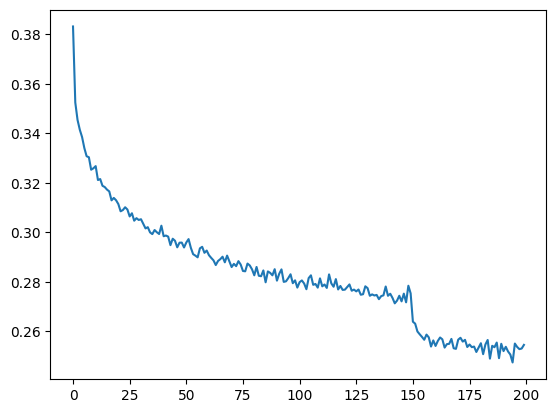

In [17]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

initial loss graph 
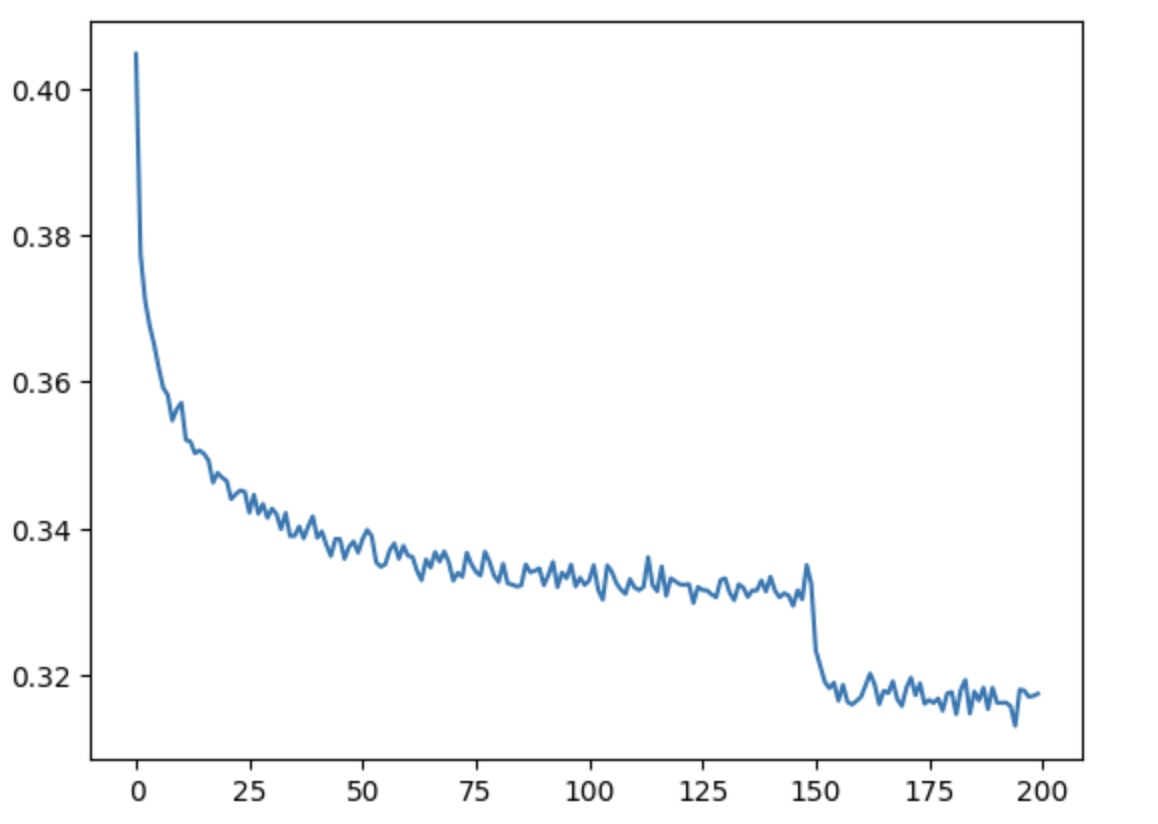

wavenet loss graph
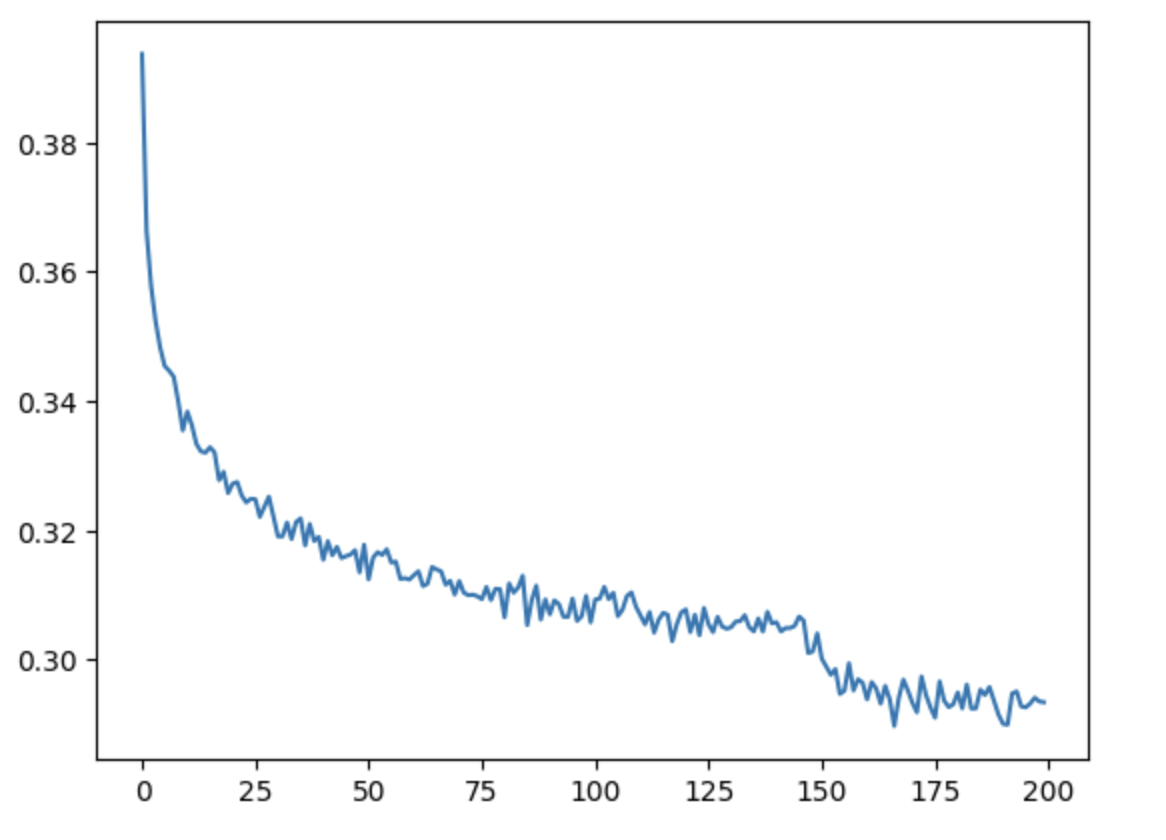

76K params
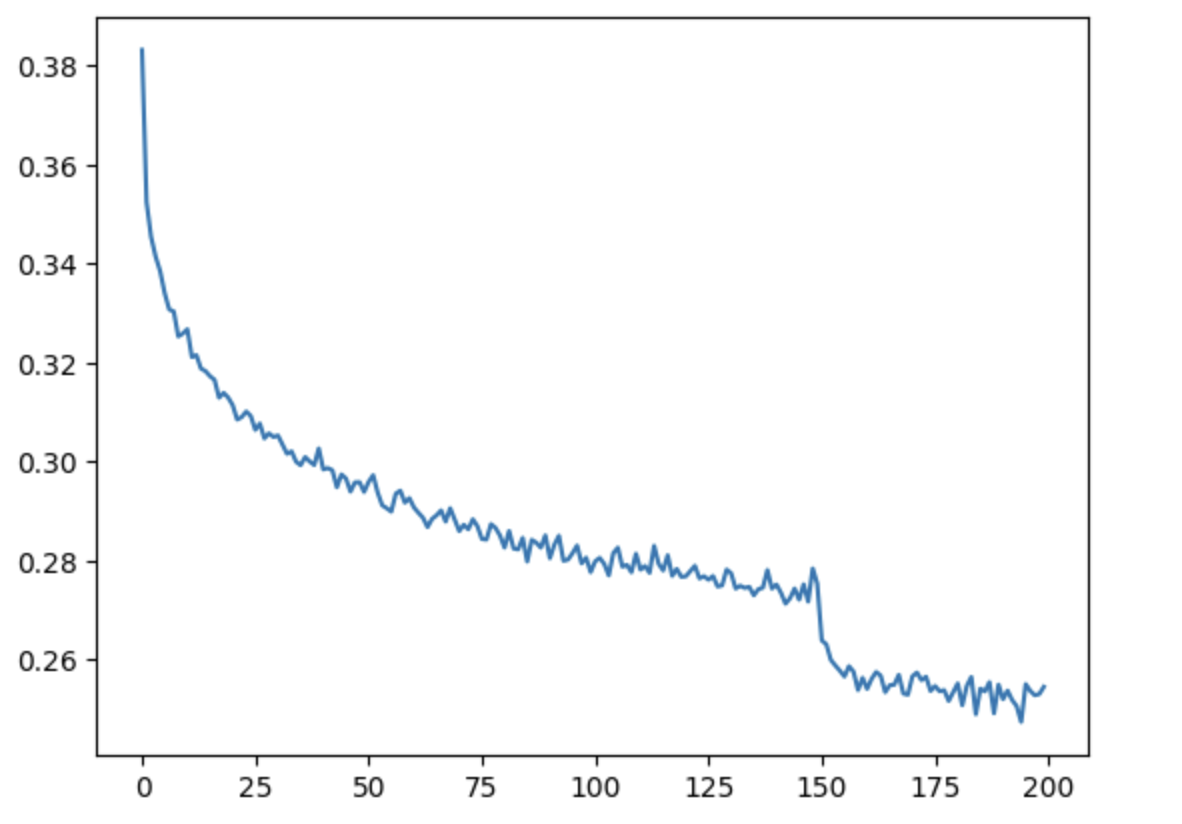

In [18]:
for layer in model.layers: 
    layer.training = False
#matters for batch norm layer mostly

In [19]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7707597017288208
val 1.9856754541397095


original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105 \
from video: context: 3 -> 8 (22K params): train 1.918, val 2.027 \
flat -> hierarchical (22K params): train 1.937 val 2.033 \
scale up network: n_embd 24, n_hidden 128 (76K params): train 1.771 val 1.986

In [21]:
g = torch.Generator().manual_seed(2147483647 + 1)
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #forward pass
        logits = model(torch.tensor([context])) # (1,block_size,d)
        probs = F.softmax(logits, dim = 1)
        
        #sample from probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        #shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # break for the '.'
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

aanjah.
ortslei.
emmere.
eiden.
laven.
bair.
unai.
beckstam.
jarahmy.
sophie.
grytn.
eduar.
juaney.
aleahi.
jajon.
xyler.
axe.
shialy.
annalisjuoquas.
ester.


initial network
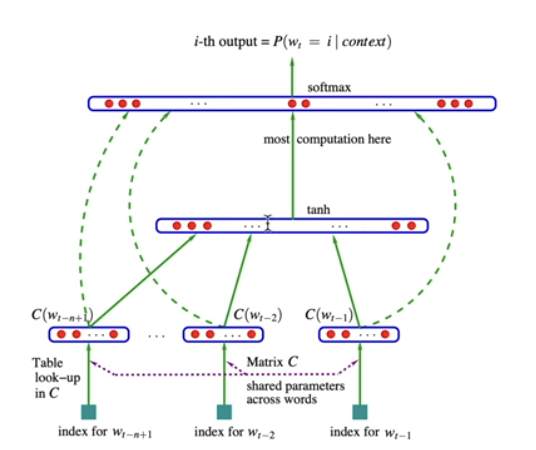

the problem is that we are squashing all of our info at once. We can make it perform better by adding more layers and expand in that sense but overall, that will only account for tiny more efficiencies as time goes forward. Instead we are crushing all of our characters into a single layer in the beginning. It doesnt make sense to do it so fast.

wavenet
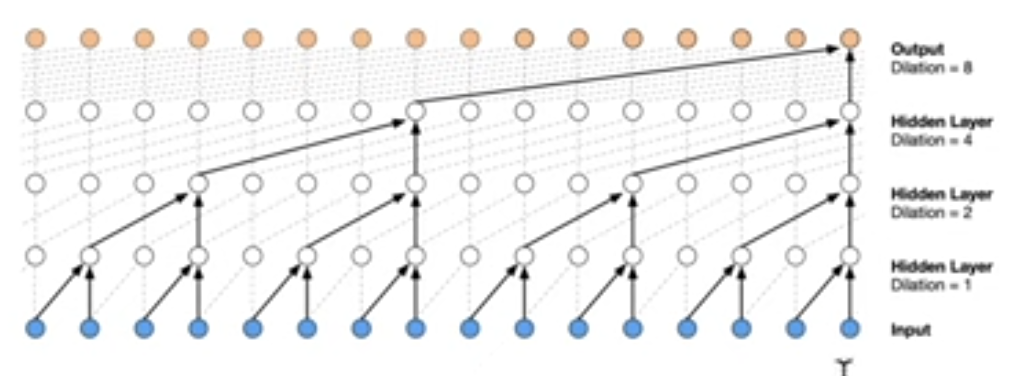

instead the characters are now gradually "crushed". we take two characters and fuse them into bigrams, and then we fuse it to 4 character chunks, then pair 2 4 chunks, and etc. Basically, we are making the network deeper but we are adding progressive fusion: at each level, we are slowly fusing characters. 

advantages:
- Information flows through more depth, allowing richer non-linear transformations at multiple scales.

- The model can learn more local patterns early on and only merge everything at higher levels when necessary.

- This approach mimics how CNNs and Wavenet work—gradually expanding the receptive field.

- Computationally, it can also be more efficient because each layer only works on local connections rather than a big full connection from the start.

to remind myself in the future, the thing that is being concatenated right now is the context over time. here is a prototype of what is going on \
4 batch size 8 context\
1, 2, 3, 4, 5, 6, 7, 8\
1, 2, 3, 4, 5, 6, 7, 8\
1, 2, 3, 4, 5, 6, 7, 8\
1, 2, 3, 4, 5, 6, 7, 8\
\
this array of 4, 8 also has a 10 d embedding attached to each character
so : [4, 8, 10] \
\
now instead of flattening all of the 8 context with the 10d embeddings to get [4, 80], we instead are going to sequentially flatten them\
\
so \
(1, 2), (3, 4), (5, 6), (7, 8)\
(1, 2), (3, 4), (5, 6), (7, 8)\
(1, 2), (3, 4), (5, 6), (7, 8)\
(1, 2), (3, 4), (5, 6), (7, 8)\
which will yield [4, 4, 20]

then we want our linear layer to convert the 20 to a 200 instead of the 80 to finally output [4, 4, 200] for our weights and biases

later on in the wave net, we can pair the bigrams to get 4-grams and pair the 4-grams to get 8-grams

for the future (convolutions):

- Convolution = sliding a small weight filter across the input to capture local patterns.

- It applies the same weights (shared parameters) at every position → efficient and position-invariant.

- Replaces slow loops with fast, parallel computation (especially on GPUs).

- Common in images (2D), audio/text (1D), capturing local features like edges or n-grams.

- Think of it like a rolling window of linear layers.

We get to see into development process of building deep networks

 - spend a lot of time on pytorch documentation \
 unfortunately, the documentation isnt very well maintained
 - a ton of trying to make the shapes work\
 are they 2, 3, 4 dimensional, what shapes are the layers, ncl or nlc, permuting or muting?
 - prototype everythign in jupyter notebook, then copy paste it into repository and kick off there with vscode

right now we are just guess and checking but usually we are looking at a ton of plots and checking what is working and what is not working, set stuff up and etc, so this is not how we properly do it. right now many values chosen here were very random

in the future, still need to cover RNNs, GRU, transformers, etc.